# RL coursework, part I (20 pts total)
---

**Name:** Enric Balaguer Rodon

**SN:** 

---

**Due date:** *April 11th, 2024*

---

Standard UCL policy (including grade deductions) automatically applies for any late submissions.

## How to submit

When you have completed the exercises and everything has finished running, click on 'File' in the menu-bar and then 'Download .ipynb'. This file must be submitted to Moodle named as **`<studentnumber>_RL_part1.ipynb`** before the deadline above, where `<studentnumber>` is your student number.

**Context**

In this assignment, we will take a first look at learning decisions from data.  For this, we will use the multi-armed bandit framework.

**Background reading**

* Sutton and Barto (2018), Chapters 1 to 6
* Lecture slides

**Overview of this assignment**

A) You will use Python to implement several bandit algorithms.

B) You will then run these algorithms on a multi-armed Bernoulli bandit problem, and answer question about their empirical performance.

C) You will then be asked to reason about the behaviour of different algorithms

## Setup

Run each of the cells below, until you reach the next section **Basic Agents**. You do not have to read or understand the code in the **Setup** section.  After running the cells, feel free to fold away the **Setup** section.

In [1]:
# Import Useful Libraries

import collections
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
import types

np.set_printoptions(precision=3, suppress=1)
# print(plt.style.available)
plt.style.use('seaborn-v0_8-notebook')

In [2]:
class BernoulliBandit(object):
  """A stationary multi-armed Bernoulli bandit."""

  def __init__(self, success_probabilities, success_reward=1., fail_reward=0.):
    """Constructor of a stationary Bernoulli bandit.

    Args:
      success_probabilities: A list or numpy array containing the probabilities,for each of the arms, of providing a success reward.
      success_reward: The reward on success (default: 1.)
      fail_reward: The reward on failure (default: 0.)
    """
    self._probs = success_probabilities
    self._number_of_arms = len(self._probs)
    self._s = success_reward
    self._f = fail_reward

    ps = np.array(success_probabilities)
    self._values = ps * success_reward + (1 - ps) * fail_reward

  def step(self, action):
    """The step function.

    Args:
      action: An integer or np.int32 that specifies which arm to pull.

    Returns:
      A reward sampled according to the success probability of the selected arm.

    Raises:
      ValueError: when the provided action is out of bounds.
    """
    if action < 0 or action >= self._number_of_arms:
      raise ValueError('Action {} is out of bounds for a '
                       '{}-armed bandit'.format(action, self._number_of_arms))

    success = bool(np.random.random() < self._probs[action])
    reward = success * self._s + (not success) * self._f
    return reward

  def regret(self, action):
    """Computes the regret for the given action."""
    return self._values.max() - self._values[action]

  def optimal_value(self):
    """Computes the regret for the given action."""
    return self._values.max()


In [3]:
class NonStationaryBandit(object):
  """A non-stationary multi-armed Bernoulli bandit."""

  def __init__(self, success_probabilities,
               success_reward=1., fail_reward=0., change_point=800,
               change_is_good=True):
    """Constructor of a non-stationary Bernoulli bandit.

    Args:
      success_probabilities: A list or numpy array containing the probabilities,
          for each of the arms, of providing a success reward.
      success_reward: The reward on success (default: 1.)
      fail_reward: The reward on failure (default: 0.)
      change_point: The number of steps before the rewards change.
      change_is_good: Whether the rewards go up (if True), or flip (if False).
    """
    self._probs = success_probabilities
    self._number_of_arms = len(self._probs)
    self._s = success_reward
    self._f = fail_reward
    self._change_point = change_point
    self._change_is_good = change_is_good
    self._number_of_steps_so_far = 0

    ps = np.array(success_probabilities)
    self._values = ps * success_reward + (1 - ps) * fail_reward

  def step(self, action):
    """The step function.

    Args:
      action: An integer or np.int32 that specifies which arm to pull.

    Returns:
      A reward sampled according to the success probability of the selected arm.

    Raises:
      ValueError: when the provided action is out of bounds.
    """
    if action < 0 or action >= self._number_of_arms:
      raise ValueError('Action {} is out of bounds for a '
                       '{}-armed bandit'.format(action, self._number_of_arms))

    self._number_of_steps_so_far += 1
    success = bool(np.random.random() < self._probs[action])
    reward = success * self._s + (not success) * self._f

    if self._number_of_steps_so_far == self._change_point:
      # After some number of steps, the rewards are inverted
      #
      #  ``The past was alterable. The past never had been altered. Oceania was
      #    at war with Eastasia. Oceania had always been at war with Eastasia.``
      #            - 1984, Orwell (1949).
      reward_dif = (self._s - self._f)
      if self._change_is_good:
        self._f = self._s + reward_dif
      else:
        self._s -= reward_dif
        self._f += reward_dif

      # Recompute expected values when the rewards change
      ps = np.array(self._probs)
      self._values = ps * self._s + (1 - ps) * self._f

    return reward

  def regret(self, action):
    """Computes the regret for the given action."""
    return self._values.max() - self._values[action]

  def optimal_value(self):
    """Computes the regret for the given action."""
    return self._values.max()

In [4]:
# Helper functions

def smooth(array, smoothing_horizon=100., initial_value=0.):
  """Smoothing function for plotting."""
  smoothed_array = []
  value = initial_value
  b = 1./smoothing_horizon
  m = 1.
  for x in array:
    m *= 1. - b
    lr = b/(1 - m)
    value += lr*(x - value)
    smoothed_array.append(value)
  return np.array(smoothed_array)

def plot(algs, plot_data, repetitions=30):
  """Plot results of a bandit experiment."""
  algs_per_row = 4
  n_algs = len(algs)
  n_rows = (n_algs - 2)//algs_per_row + 1
  fig = plt.figure(figsize=(10, 4*n_rows))
  fig.subplots_adjust(wspace=0.3, hspace=0.35)
  clrs = ['#000000', '#00bb88', '#0033ff', '#aa3399', '#ff6600']
  lss = ['--', '-', '-', '-', '-']
  for i, p in enumerate(plot_data):
    for c in range(n_rows):
      ax = fig.add_subplot(n_rows, len(plot_data), i + 1 + c*len(plot_data))
      ax.grid(0)

      current_algs = [algs[0]] + algs[c*algs_per_row + 1:(c + 1)*algs_per_row + 1]
      for alg, clr, ls in zip(current_algs, clrs, lss):
        data = p.data[alg.name]
        m = smooth(np.mean(data, axis=0))
        s = np.std(smooth(data.T).T, axis=0)/np.sqrt(repetitions)
        if p.log_plot:
          line = plt.semilogy(m, alpha=0.7, label=alg.name,
                              color=clr, ls=ls, lw=3)[0]
        else:
          line = plt.plot(m, alpha=0.7, label=alg.name,
                          color=clr, ls=ls, lw=3)[0]
          plt.fill_between(range(len(m)), m + s, m - s,
                           color=line.get_color(), alpha=0.2)
      if p.opt_values is not None:
        plt.plot(p.opt_values[current_algs[0].name][0], ':', alpha=0.5,
                 label='optimal')

      ax.set_facecolor('white')
      ax.tick_params(axis="both", which="both", bottom="off", top="off",
                     labelbottom="on", left="off", right="off", labelleft="on")
      ax.spines["top"].set_visible(False)
      ax.spines["bottom"].set(visible=True, color='black', lw=1)
      ax.spines["right"].set_visible(False)
      ax.spines["left"].set(visible=True, color='black', lw=1)
      ax.get_xaxis().tick_bottom()
      ax.get_yaxis().tick_left()

      data = np.array([smooth(np.mean(d, axis=0)) for d in p.data.values()])

      if p.log_plot:
        start, end = calculate_lims(data, p.log_plot)
        start = np.floor(np.log10(start))
        end = np.ceil(np.log10(end))
        ticks = [_*10**__
                 for _ in [1., 2., 3., 5.]
                 for __ in [-2., -1., 0.]]
        labels = [r'${:1.2f}$'.format(_*10** __)
                  for _ in [1, 2, 3, 5]
                  for __ in [-2, -1, 0]]
        plt.yticks(ticks, labels)
      plt.ylim(calculate_lims(data, p.log_plot))
      plt.locator_params(axis='x', nbins=4)

      plt.title(p.title)
      if i == len(plot_data) - 1:
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

def run_experiment(bandit_constructor, algs, repetitions, number_of_steps):
  """Run multiple repetitions of a bandit experiment."""
  reward_dict = {}
  regret_dict = {}
  optimal_value_dict = {}

  for alg in algs:
    reward_dict[alg.name] = np.zeros((repetitions, number_of_steps))
    regret_dict[alg.name] = np.zeros((repetitions, number_of_steps))
    optimal_value_dict[alg.name] = np.zeros((repetitions, number_of_steps))

    for _rep in range(repetitions):
      bandit = bandit_constructor()
      alg.reset()

      action = None
      reward = None
      for _step in range(number_of_steps):
        action = alg.step(action, reward)
        reward = bandit.step(action)
        regret = bandit.regret(action)
        optimal_value = bandit.optimal_value()

        reward_dict[alg.name][_rep, _step] = reward
        regret_dict[alg.name][_rep, _step] = regret
        optimal_value_dict[alg.name][_rep, _step] = optimal_value

  return reward_dict, regret_dict, optimal_value_dict


def train_agents(agents, number_of_arms, number_of_steps, repetitions=100,
                 success_reward=1., fail_reward=0.,
                 bandit_class=BernoulliBandit):

  success_probabilities = np.arange(0.3, 0.7 + 1e-6, 0.4/(number_of_arms - 1))

  bandit_constructor = partial(bandit_class,
                               success_probabilities=success_probabilities,
                               success_reward=success_reward,
                               fail_reward=fail_reward)
  rewards, regrets, opt_values = run_experiment(
      bandit_constructor, agents, repetitions, number_of_steps)

  smoothed_rewards = {}
  for agent, rs in rewards.items():
    smoothed_rewards[agent] = np.array(rs)

  PlotData = collections.namedtuple('PlotData',
                                    ['title', 'data', 'opt_values', 'log_plot'])
  total_regrets = dict([(k, np.cumsum(v, axis=1)) for k, v in regrets.items()])
  plot_data = [
      PlotData(title='Smoothed rewards', data=smoothed_rewards,
               opt_values=opt_values, log_plot=False),
      PlotData(title='Current Regret', data=regrets, opt_values=None,
               log_plot=True),
      PlotData(title='Total Regret', data=total_regrets, opt_values=None,
               log_plot=False),
  ]

  plot(agents, plot_data, repetitions)

def calculate_lims(data, log_plot=False):
  y_min = np.min(data)
  y_max = np.max(data)
  diff = y_max - y_min
  if log_plot:
    y_min = 0.9*y_min
    y_max = 1.1*y_max
  else:
    y_min = y_min - 0.05*diff
    y_max = y_max + 0.05*diff
  return y_min, y_max

def argmax(array):
  """Returns the maximal element, breaking ties randomly."""
  return np.random.choice(np.flatnonzero(array == array.max()))

# A) Agent implementations


All agents should be in pure Python/NumPy.

You cannot use any AutoDiff packages (Jax, TF, PyTorch, etc.)

Each agent, should implement the following methods:

**`step(self, previous_action, reward)`:**

Should update the statistics by updating the value for the previous_action towards the observed reward.

(Note: make sure this can handle the case that previous_action=None, in which case no statistics should be updated.)

(Hint: you can split this into two steps: 1. update values, 2. get new action.  Make sure you update the values before selecting a new action.)

**`reset(self)`:**

Resets statistics (should be equivalent to constructing a new agent from scratch).

Make sure that the initial values (after a reset) are all zero.

**`__init__(self, name, number_of_arms, *args)`:**

The `__init__` should take at least an argument `number_of_arms`, and (potentially) agent specific args.

## Example agent

The following code block contains an example random agent.

In [5]:
class Random(object):
  """A random agent.

  This agent returns an action between 0 and 'number_of_arms', uniformly at
  random. The 'previous_action' argument of 'step' is ignored.
  """

  def __init__(self, name, number_of_arms):
    """Initialise the agent.

    Sets the name to `random`, and stores the number of arms. (In multi-armed
    bandits `arm` is just another word for `action`.)
    """
    self._number_of_arms = number_of_arms
    self.name = name

  def step(self, unused_previous_action, unused_reward):
    """Returns a random action.

    The inputs are ignored, but this function still requires an action and a
    reward, to have the same interface as other agents who may use these inputs
    to learn.
    """
    return np.random.randint(self._number_of_arms)

  def reset(self):
    pass


## Q1 [2 pts]
Implement a UCB agent.

The `bonus_multiplier` is the parameter $c$ from the slides.

In [6]:
class UCB(object):
  def __init__(self, name, number_of_arms, bonus_multiplier):
    self._number_of_arms = number_of_arms
    self._bonus_multiplier = bonus_multiplier
    self.name = name
    self.reset()

  def step(self, previous_action, reward):
    if previous_action == None:
      #Random action to begin with
      action = np.random.randint(self._number_of_arms)
      
    else:
      self.t += 1

      #Update N first
      self.N[previous_action] += 1

      #Update Q
      self.Q[previous_action] += (reward - self.Q[previous_action])/self.N[previous_action]
      # self.Q[previous_action] = ((self.Q[previous_action]*(self.N[previous_action]-1)) + reward)/self.N[previous_action]

      #Generate action pool and argmax it
      action = np.argmax(self.Q + self._bonus_multiplier*np.sqrt(np.log(self.t)/(self.N+1))) 
      #I add 1 on denominator to deal with dividing by 0 issues, it doesn't affect the result of the argmax

    return action

  def reset(self):
    self.t = 0
    self.N = np.zeros([self._number_of_arms])
    self.Q = np.zeros([self._number_of_arms])
    

## Q2 [1 pt]
Implement an $\epsilon$-greedy agent.

This agent should be able to support time-changing $\epsilon$ schedules.

Thus, your agent should accept both constants and callables as constructor argument `epsilon`; callables are used to decay the $\epsilon$ parameter over time, for instance according to a polynomial schedule: $\epsilon_t = t^{-\eta}$ with $\eta \in [0, 1]$).


If multiple actions have the same value, ties should be broken randomly.

In [7]:
class EpsilonGreedy(object):
  """An epsilon-greedy agent.

  This agent returns an action between 0 and 'number_of_arms'; with probability
  `(1-epsilon)` it chooses the action with the highest estimated value, while
  with probability `epsilon` it samples an action uniformly at random.
  """

  def __init__(self, name, number_of_arms, epsilon=0.1):
    self._number_of_arms = number_of_arms
    self._epsilon = epsilon
    self.name = name
    self.reset()

  def step(self, previous_action, reward):
    """Update the learnt statistics and return an action.

    A single call to step uses the provided reward to update the value of the
    taken action (which is also provided as an input), and returns an action.
    The action is either uniformly random (with probability epsilon), or greedy
    (with probability 1 - epsilon).

    If the input action is None (typically on the first call to step), then no
    statistics are updated, but an action is still returned.
    """
    if previous_action == None:
      action = np.random.randint(self._number_of_arms)

    else:
      #Update statistics first
      self.t += 1
      if isinstance(self._epsilon, types.FunctionType):
        epsilon = self._epsilon(self.t)
      else:
        epsilon = self._epsilon

      self.N[previous_action] += 1
      self.Q[previous_action] += (reward - self.Q[previous_action])/self.N[previous_action]
      # self.Q[previous_action] = ((self.Q[previous_action]*(self.N[previous_action]-1)) + reward)/self.N[previous_action]

      #Decide random action or greedy one
      random_or_greedy = bool(np.random.random() < epsilon)
      if random_or_greedy == True:
        action = np.random.randint(self._number_of_arms)
      else:
        # action = np.argmax(self.Q) --> Wrong, not choosing equal values at random
        #Find max value
        max_value = np.max(self.Q)
        #Find indices that equal max value
        max_indices = np.where(self.Q == max_value)[0]
        #Choose randomly
        action = np.random.choice(max_indices)

    return action

  def reset(self):
    self.t = 0
    self.N = np.zeros(self._number_of_arms)
    self.Q = np.zeros(self._number_of_arms)

## Q3 [2 pts]
Implement a REINFORCE agent.

While `softmax` distributions are a common parametrization for policies over discrete action-spaces, they are not the only choice. In this exercise we ask you to implement REINFORCE with the `square-max` policy parameterization. With this parametrisation the probabilities depend on the action preferences $p(\cdot)$ according to the expression:

$$\pi(a) = \frac{p(a)^2}{\sum_b p(b)^2}\,.$$

Implement a REINFORCE policy-gradient method for updating the preferences under this policy distribution. The action preferences are stored separately, so that for each action $a$ the preference $p(a)$ is a single value that you directly update.

The agent should be able to use a baseline or not (as defined in the constructor). The `step_size` parameter $\alpha$ used to update the policy must also be configurable in the constructor.

The baseline should track the average reward so far, using the same `step_size` used to update the policy.

The `step_size` and whether or not a baseline is used are defined in the constructor by feeding additional arguments in place of `...` below.


In [8]:
class REINFORCE(object):
  def __init__(self, name, number_of_arms, step_size=0.1, baseline=False):
    self._number_of_arms = number_of_arms
    self._step_size = step_size
    self._baseline = baseline
    self.name = name
    self.reset()

  def step(self, previous_action, reward):
    if previous_action == None:
      action = np.random.randint(self._number_of_arms)
      return action
    
    #Update statistics
    self.t += 1
    self.avg_reward += (1/self.t)*(reward-self.avg_reward)
    if self._baseline:
      baseline_average = self.avg_reward
    else:
      baseline_average = 0

    #"Backpropagate" for previous action. I do it analytically.
    self.theta[previous_action] += 2*self._step_size*(reward-baseline_average)*((1/self.theta[previous_action]) - (self.theta[previous_action]/np.sum(np.square(self.theta))))
    indices = (np.arange(self._number_of_arms) != previous_action)
    self.theta[indices] -= 2*self._step_size*(reward-baseline_average)*(self.theta[indices]/np.sum(np.square(self.theta)))

    #"Feedforward"
    self.policy_probs = np.square(self.theta)/np.sum(np.square(self.theta))

    #Decide action via categorical distribution
    action = np.random.choice(self._number_of_arms, p=self.policy_probs)

    return action

  def reset(self):
    self.theta = np.ones(self._number_of_arms)
    self.policy_probs = np.square(self.theta)/np.sum(np.square(self.theta))
    self.t = 0
    self.avg_reward = 0

# B) Experiments

**Run the cell below to train the agents and generate the plots for the first experiment.**

Trains the agents on a Bernoulli bandit problem with 5 arms,
with a reward on success of 1, and a reward on failure of 0.

## Experiment 1: Bernoulli bandit

In [9]:
%%capture experiment1

number_of_arms = 5
number_of_steps = 1000

agents = [
    Random(
        "random",
        number_of_arms),
    EpsilonGreedy(
        r"$\epsilon$-greedy with $\epsilon=0$",
        number_of_arms,
        epsilon=0.),
    EpsilonGreedy(
        r"$\epsilon$-greedy with $\epsilon=0.1$",
        number_of_arms,
        epsilon=0.1),
    EpsilonGreedy(
        r"$\epsilon$-greedy with $\epsilon_t=1/t$",
        number_of_arms,
        epsilon=lambda t: 1./t),
    EpsilonGreedy(
        r"$\epsilon$-greedy with $\epsilon_t=1/\sqrt{t}$",
        number_of_arms,
        epsilon=lambda t: 1./t**0.5),
    UCB("UCB",
        number_of_arms,
        bonus_multiplier=1/np.sqrt(2)),
    REINFORCE(
        r"REINFORCE, $\alpha=0.1$",
        number_of_arms,
        step_size=0.1,
        baseline=False),
    REINFORCE(
        r"REINFORCE with baseline, $\alpha=0.1$",
        number_of_arms,
        step_size=0.1,
        baseline=True),
]

train_agents(agents, number_of_arms, number_of_steps)

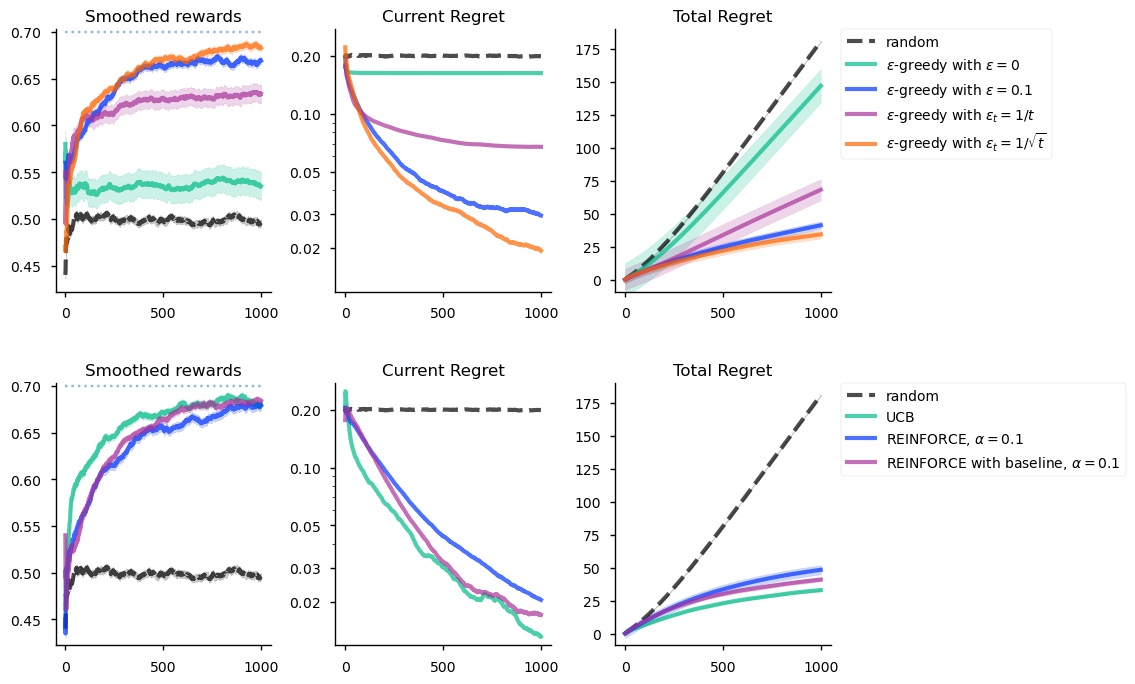

In [10]:
experiment1.show()

## Q4 [4 pts total]
(Answer inline in the markdown below each question, **within this text cell**.)

**[2 pts]**
For each algorithm in the plots above, explain whether or not we should be expected it to be good in general, in terms of total regret.

In order to minimise regret in the provided multi-armed Bernoulli bandit, we want to use an algorithm that balances exploration vs exploitation. In one hand, we want to maximise the actions we have experienced to produce most reward, and in the other, we also want to make sure we explore all the possible actions available enough times, to make sure we are not missing potential better actions that might minimise our regret. Taking this into consideration, let's go over the different algorithms.

- Greedy algorithm ($\epsilon$-greedy with $\epsilon=0$):
I expect this algorithm to perform the worst, as it does not ever explore, thus missing out on better actions, maximising regret.

- $\epsilon$-greedy algorithm:
This algorithm does trade exploration vs exploitation. However, I expect its performance to depend purely on the choice of $\epsilon$ value. I will go into more detail in the next section, but for now, I expect this algorithm to perform well, decreasing "growth of regret" as time progresses, depending on $\epsilon$ value.

- REINFORCE algorithm:
This algorithm also trades exploration vs exploitation, consequently, I also expect it to perform well, minimising regret over time. However, I expect REINFORCE with baseline to outperform REINFORCE without a baseline. When there is no baseline, every action that provides a positive reward "backpropagates" its gradient back to the algorithm's actions preferences, only scaled by the magnitude of the reward itself. (negative rewards also backpropagate but change preferences for the worse). When baseline is present, all actions get compared to the current reward average, allowing best actions to stand out the most while worst actions are "punished" even harsher.

- UCB algorithm:
This algorithm also trades exploration vs exploitation, consequently, I also expect it to perform well, minimising regret over time. The fact that UCB chooses actions with either big Q (exploitation) or big U (exploration) will make it an algorithm that minimises regret. However, I am unsure about how it will compare with the rest of algorithms.

- Actual practical results:
We can see from the results that indeed greedy algorithm performs the worst, while the rest do indeed minimise regret. However, only some appear to reach an asymptotic limit of total regret, others would need more iterations to really determine such behaviour. The best performers are UCB algorithm, REINFORCE with baseline and $\epsilon$ greedy with $\epsilon = \frac{1}{\sqrt t}$. The absolute best performer appears to be UCB, reaching the lowest current regret given 1000 time-steps, although REINFORCE with baseline is pretty much comparable.

- Please note: 
All the comments on this section on the different algorithms are not general to every environment, I am just describing their behaviour within their expected behaviour and performance given a Multiarmed Bernoulli bandit

**[2 pts]** Explain the relative ranking of the $\epsilon$-greedy algorithms in this experiment.

1. $\epsilon$-greedy with $\epsilon = \frac{1}{\sqrt t}$:
This is clearly the best $\epsilon$-greedy algorithm. Not only will it reach optimal policy as $t \rightarrow \infty$, but it also minimises regret during inital time-steps better than any other $\epsilon$-greedy algorithm. When compared to $\epsilon$-greedy with $\epsilon = \frac{1}{t}$, it appears that more exploration for a longer period of time is needed to perform the best in this experiment. This extra exploration is provided by the square root to time in the epsilon's denominator.

2. $\epsilon$-greedy with $\epsilon = 0.1$: 
Although this algorithm will generate a good policy as $t \rightarrow \infty$, it will never reach optimal policy. This is because it will never stop exploring, consequently, its policy will never be deterministic, it will always have a 10% chance of choosing a random action. However, we can see that it minimises current and total regret significantly more than $\epsilon$-greedy with $\epsilon = \frac{1}{t}$, this difference is made clearer when increasing number_of_steps. As such, this algorithm can be better at accommodating objectives other than finding optimal policy, such as minimising regret given finite time steps.

3. $\epsilon$-greedy with $\epsilon = \frac{1}{t}$:
This algorithm will generate optimal policy in the limit of $t \rightarrow \infty$, since it is guaranteed that it will have explored all possible actions and it will be deterministic in the limit, since $\epsilon$ reaches zero. But as mentioned above, it does minimise regret significantly worse than $\epsilon$-greedy with $\epsilon = 0.1$ over finite amount of time-steps. This is due to its exploration capability ($\epsilon$) being diminished too fast.

4. Greedy algorithm ($\epsilon$-greedy with $\epsilon=0$): 
As explained above, this algorithm is expected to perform the worse due to its lack of exploration, maximising regret by missing out on possible better actions.








## Experiment 2: reward = 0 on success, reward = -1 on failure.

**Run the cell below to train the agents and generate the plots for the second experiment.**
Reruns experiment 1 but on a different bernoulli bandit problem with 5 arms,
with a reward on success of 0, and a reward on failure of -1.

---



In [11]:
%%capture experiment2
number_of_arms = 5
number_of_steps = 1000

train_agents(agents, number_of_arms, number_of_steps,
             success_reward=0., fail_reward=-1.)

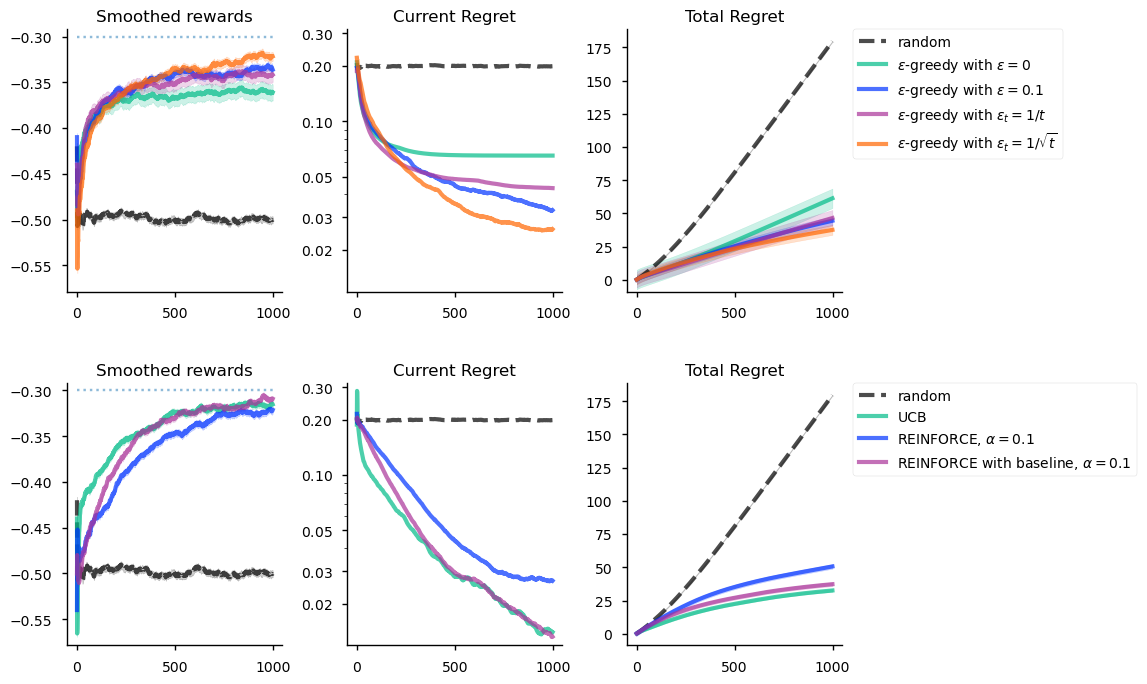

In [12]:
experiment2.show()

## Q5 [2 pts]
For each algorithm, note whether the performance changed significantly compared to the **experiment 1**, and explain why it did or did not.

(Use at most two sentences per algorithm).

-UCB and $\epsilon$-greedy with $\epsilon = \frac{1}{\sqrt t}$:\
Two of the best performing algorithms from the previous environment continue to excel in this one. UCB and $\epsilon$-greedy with $\epsilon = \frac{1}{\sqrt t}$ excell at balancing exploration of possible better actions and exploitation of current best actions. Further, UCB appears to still be the absolute best performer, minimising regret the fastest.

-Greedy algorithm ($\epsilon$-greedy with $\epsilon=0$):\
The greedy algorithm sees a considerable improvement in performance in this experiment. This environment "forces" greedy behaviour to explore. Rewards are negative or 0. If the picked action returns the best reward, it will still randomly be picked next time-step, Q(a)=0 (same as unpicked actions).

-$\epsilon$-greedy with $\epsilon = 0.1$ and $\epsilon$-greedy with $\epsilon = \frac{1}{t}$:\
$\epsilon$-greedy with $\epsilon = 0.1$ still outperforms $\epsilon$-greedy with $\epsilon = \frac{1}{t}$ given limited amount of time-steps. However, the latter greatly improves its performance for the same reasons as the greedy algorithm. Once again, $\epsilon$-greedy with $\epsilon = 0.1$ will never reach optimal policy in the limit of $t \rightarrow \infty$, while $\epsilon$-greedy with $\epsilon = \frac{1}{t}$ will. However, $\epsilon$-greedy with $\epsilon = 0.1$ severly outperforms $\epsilon$-greedy with $\epsilon = \frac{1}{t}$ in minimising total regret. This is made even more evident when increasing number of timesteps.

-REINFORCE algorithm without baseline:\
This algorithm seems to perform slightly worse in this experiment. This can be explained by the fact that it only ever punishes wrong actions, never rewarding good ones due to reward system. This bring slower learning due to only ever learning actions to stay away from.

-REINFORCE algorithm with a baseline:\
In the contrary, when you add a baseline to REINFORCE, it appears to improve its performance compared to the last experiment, reaching same current regret than UCB. This can be explained by the fact that the algorithm can learn from both good and bad actions thanks to the baseline.


## Run the following cells

## Experiment 3: Non-stationary bandit
 * Reward on `failure` changes from 0 to +2.
 * Reward on `success` remains at +1.


In [13]:
%%capture experiment3

number_of_arms = 3
number_of_steps = 1984
agents = [
    Random(
        "random",
        number_of_arms),
    EpsilonGreedy(
        r"$\epsilon$-greedy with $\epsilon=0.1$",
        number_of_arms,
        epsilon=0.1),
    EpsilonGreedy(
        r"$\epsilon$-greedy with $\epsilon_t=1/\sqrt{t}$",
        number_of_arms,
        epsilon=lambda t: 1./t**0.5),
    UCB("UCB",
        number_of_arms,
        bonus_multiplier=1/np.sqrt(2)),
    REINFORCE(
        r"REINFORCE with baseline, $\alpha=0.1$",
        number_of_arms,
        step_size=0.1,
        baseline=True),

]

roving_bandit_class = partial(NonStationaryBandit, change_is_good=True)
train_agents(agents, number_of_arms, number_of_steps,
             bandit_class=roving_bandit_class)

## Experiment 4: Non-stationary bandit
 * Reward on `failure` changes from 0 to +1.
 * Reward on `success` changes from +1 to 0.


In [14]:
%%capture experiment4

number_of_arms = 3
number_of_steps = 1984


roving_bandit_class = partial(NonStationaryBandit, change_is_good=False)
train_agents(agents, number_of_arms, number_of_steps,
             bandit_class=roving_bandit_class)

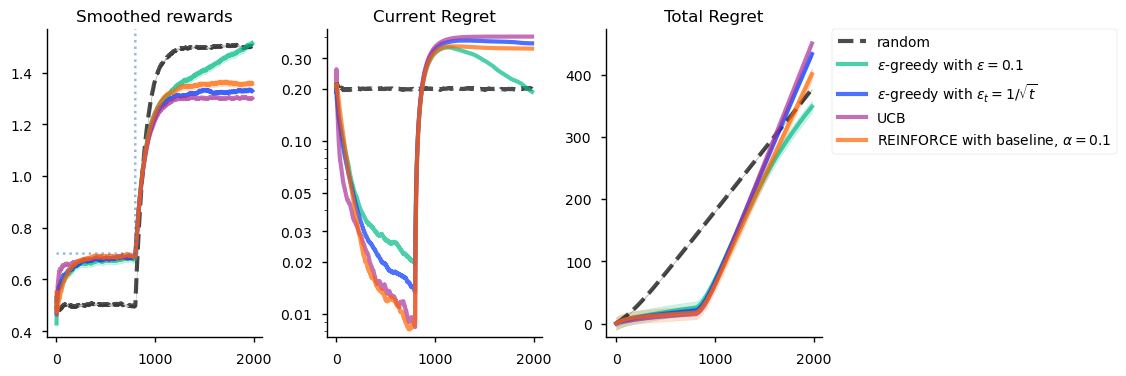

In [15]:
experiment3.show()

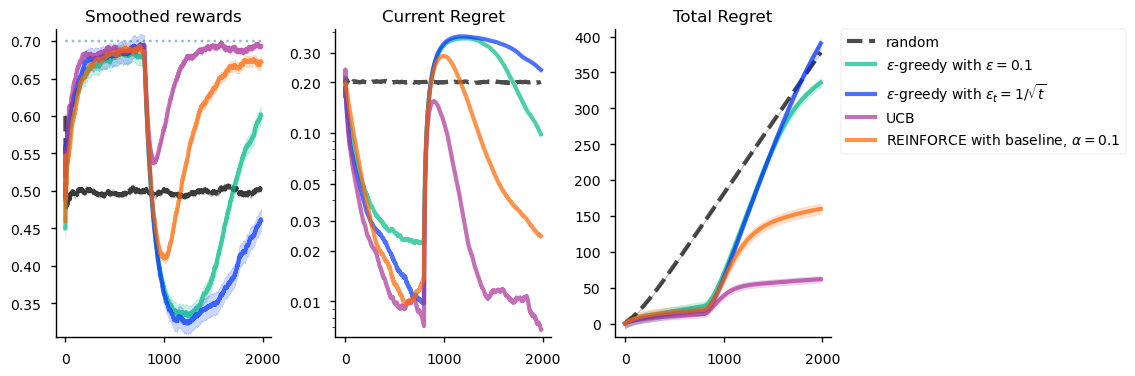

In [16]:
experiment4.show()

## Q6 [9 pts total]

Observe the reward and regret curves above.  After 800 steps, the rewards change. In **experiment 3** `success` continues to yield a reward of +1, but `failure` changes from a reward of 0 to a reward of +2.  In **experiment 4**, `success` is now worth 0 and `failure` is worth +1.

Below, we ask for explanations.  Answer each question briefly, using at most three sentences per question.

**[2 pts]** In **experiment 3** explain the ranking in current regret after the change in rewards for all algorithms. 
> $\epsilon$-greedy with $\epsilon=0.1$ is the best as it explores always, having the ability to recognise better actions after the rewards change. The other three algorithms "lose" their ability to explore after 1k steps and stick to picking their own "optimum" actions. Consequently, the algorithms performing the best before the change, also perform the worst after it (bad performance pre-change means picking actions that later perform better).

**[2 pts]** In **experiment 4** explain the ranking in current regret after the change in rewards for all algorithms.

> Contrary to experiment3, the rewards of pre-change "optimum" actions diminish. This allows the "metrics/statistics" of each algorithm's actions to decrease as well, in turn increasing their capacity to explore. Consequently, we see UCB react the best to the change in rewards (Q decreases for pre-change best actions), followed by REINFORCE (backpropagates the post-change lower reward) and $\epsilon$-greedy with $\epsilon=0.1$ and with $\epsilon=\frac{1}{\sqrt t}$. 

**[2 pts]** Explain how and why the current-regret curve for UCB in **experiment 3** differs from the curve in **experiment 4**.

> Experiment4's rewards change decreases the reward for "success", meaning that the pre-change "best" actions' Q values will decrease as they continue to get picked, until they are on the same level as pre-change "worse" actions. Further, U values helps it adapt better, pre-change "worse" actions will have lower N, giving it bigger U, helping being picked post-change. This does not happen in experiment3 because Q of pre-change "best" actions will not change, thus never changing Q of pre-change "worse" actions by never picking them.

**[3 pts]** In general, if rewards can be non-stationary, and we don't know the exact nature of the non-stationarity, how could we modify UCB to perform better?   Be specific and concise.

> My initial instinct was to reset either $N(a)$ or time_step count, or both, every $x$ amount of time-steps when calculating $U(a)$ $\textbf{only}$. This way, UCB would get its uncertainty over actions reset fully (resetting both variables) or partially (only one). This would help UCB have "exploratory episodes" allowing it to more easily adapt to changes in rewards. However, after a quick search, it would probably be better implement discounted UCB, where more recent rewards are given more weight: https://arxiv.org/pdf/0805.3415.pdf
